#### References

- https://www.sciencedirect.com/science/article/pii/S037722172300382X
- https://www.sciencedirect.com/science/article/pii/S2212827120307708
- https://www.researchgate.net/publication/388529112_Investigating_the_Monte-Carlo_Tree_Search_Approach_for_the_Job_Shop_Scheduling_Problem
- https://www.sciencedirect.com/science/article/pii/S2212827122001846
- https://www.honda-ri.de/pubs/pdf/3949.pdf
- https://www.youtube.com/watch?v=UXW2yZndl7U

#### Summary
- The client requires a model that would assign engineers to tasks such that all tasks are completed within the shortest time with deadlines being met
- This requirement is a variant of the Flexible Job Shop Scheduling problem
```
A "flexible job shop scheduling problem" (FJSP) is a variation of the classic job shop scheduling problem where each operation within a job can be processed on multiple machines, meaning you have the flexibility to choose which machine to use for each operation, requiring both assignment of operations to machines and sequencing of operations on those machines to optimize a chosen objective, like minimizing overall completion time
```
- Models currently being tried
  - Reinforcement Learning
    - Formulate reward function based on maximizing completion rate and minimizing makespan and overshooting deadlines
      - RL Techniques employed:
        - Q Learning
        - Monte Carlo Tree Search
  - Heuristic
    - Greedy
      - at each stage, choose the action from allowable actions that would result in the shortest makespan
- Pending
  - How to load and transform client data to the different python objects
  - Check performance on larger datasets
  - Hyperparameter tuning
  - Instead having only one completion time per task per worker, create function where the worker task completion time would be sampled from historical completion times

#### Q Learning

In [1]:
import numpy as np
import random

# Define the FJSP Environment
class FJSP_Env:
    def __init__(self, jobs, workers, processing_times, deadlines, 
                 switch_penalty=2, ongoing_tasks = None,
                 not_same_pic=None):
        self.jobs = jobs
        self.workers = workers
        self.processing_times = processing_times
        self.deadlines = deadlines
        self.switch_penalty = switch_penalty
        self.ongoing_tasks = ongoing_tasks
        self.not_same_pic = not_same_pic
        self.reset()

    def create_copy(self):
        env_copy = FJSP_Env(
            jobs=self.jobs,
            workers=self.workers,
            processing_times=self.processing_times,
            deadlines=self.deadlines,
            switch_penalty=self.switch_penalty,
            ongoing_tasks=self.ongoing_tasks,
            not_same_pic = self.not_same_pic
        )
        env_copy.schedule = list(self.schedule)
        env_copy.completed_jobs = set(self.completed_jobs)
        env_copy.worker_time = dict(self.worker_time)
        env_copy.worker_last_job = dict(self.worker_last_job)
        env_copy.current_time = self.current_time
        env_copy.task_assignments = dict(self.task_assignments)
        return env_copy
    
    def prioritize_ongoing_tasks(self):
        '''Set ongoing tasks first in the scheduler'''
        if self.ongoing_tasks is not None:
            for job, sub_job, worker, process_time in self.ongoing_tasks:
                start_time = self.worker_time[worker]
            
                last_finished_job_time = max(
                    (end for j, _, _, _, end in self.schedule if j == job),
                    default=0
                )
                if last_finished_job_time > start_time:
                    start_time = last_finished_job_time
                        
                finish_time = start_time + process_time
                self.worker_time[worker] = finish_time
                self.worker_last_job[worker] = job
            
                self.schedule.append((job, sub_job, worker, start_time, finish_time))
                self.completed_jobs.add(sub_job)
                self.current_time = max(self.worker_time.values())

                self.task_assignments[sub_job] = worker
            
    
    def reset(self):
        self.schedule = []
        self.completed_jobs = set()
        self.worker_time = {worker: 0 for worker in self.workers}
        self.worker_last_job = {worker: None for worker in self.workers}
        self.current_time = 0
        self.task_assignments = {}
        self.prioritize_ongoing_tasks()        
        return self.get_state()

    def is_valid_action(self, job, sub_job, worker):
        if sub_job in self.completed_jobs:
            return False

        if worker not in self.processing_times.get(sub_job, {}):
            return False

        job_sequence = self.jobs[job]
        sub_job_index = job_sequence.index(sub_job)

        if sub_job_index > 0:
            required_sub_jobs = job_sequence[:sub_job_index]
            if any(req_sub not in self.completed_jobs for req_sub in required_sub_jobs):
                return False
                
        if self.not_same_pic and sub_job in self.not_same_pic:
            prev_task = self.not_same_pic[sub_job]
            prev_worker = self.task_assignments.get(prev_task)
            if prev_worker == worker:
                return False
                
        return True

    def get_possible_actions(self):
        actions = [
            (job, sub_job, worker)
            for job, sub_jobs in self.jobs.items()
            for sub_job in sub_jobs
            for worker in self.workers
            if self.is_valid_action(job, sub_job, worker)
        ]
        return actions

    def step(self, action):
        if action is None or len(action) != 3:
            return self.get_state(), -100, True
    
        job, sub_job, worker = action
        if not self.is_valid_action(job, sub_job, worker):
            return self.get_state(), -10, False
    
        process_time = self.processing_times[sub_job][worker]
        start_time = self.worker_time[worker]
    
        last_finished_job_time = max(
            (end for j, _, _, _, end in self.schedule if j == job),
            default=0
        )
        if last_finished_job_time > start_time:
            start_time = last_finished_job_time
    
        switching = self.worker_last_job[worker] is not None and self.worker_last_job[worker] != job
        if switching:
            start_time += self.switch_penalty
    
        finish_time = start_time + process_time
        self.worker_time[worker] = finish_time
        self.worker_last_job[worker] = job
    
        self.schedule.append((job, sub_job, worker, start_time, finish_time))
        self.completed_jobs.add(sub_job)
        self.current_time = max(self.worker_time.values())

        self.task_assignments[sub_job] = worker
    
        # Compute stats
        total_jobs = sum(len(subs) for subs in self.jobs.values())
    
        last_finish_times = {
            job: max((end for j, _, _, _, end in self.schedule if j == job), default=0)
            for job in self.jobs
        }
    
        overshoot_per_job = {
            job: max(0, last_finish_times[job] - self.deadlines[job])
            for job in self.jobs
        }
    
        total_overshoot = sum(overshoot_per_job.values())
    
        # Utilization: busy time / makespan
        makespan = self.current_time
        avg_busy_time = sum(self.worker_time.values()) / len(self.worker_time)
        utilization = avg_busy_time / makespan if makespan > 0 else 0
    
        # Reward
        reward = (
            -10.0 * makespan                   # minimize makespan
            - 10.0 * (1 - utilization)              # minimize idle time
            - 5.0 * total_overshoot           # penalize late jobs
            - 0.25*(self.switch_penalty if switching else 0)  # switching penalty
        )
    
        done = len(self.completed_jobs) == total_jobs
        return self.get_state(), reward, done

    def get_state(self):
        completed_vector = [
            1 if sub_job in self.completed_jobs else 0
            for job in self.jobs
            for sub_job in self.jobs[job]
        ]
        worker_loads = list(self.worker_time.values())
        return tuple(completed_vector + worker_loads)

import random
import matplotlib.pyplot as plt

class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.9, epsilon_min=0.1, init_q_value=0.0):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}
        self.init_q_value = init_q_value  # Set the initial Q-value for all state-action pairs
        self.epsilon_min = epsilon_min

    def get_state(self):
        # Compact, hashable state representation
        return (
            frozenset(self.env.completed_jobs),
            tuple(self.env.worker_time[w] for w in self.env.workers)
        )

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state, explore=True):
        actions = self.env.get_possible_actions()
        if not actions:
            return None
        if random.uniform(0, 1) < self.epsilon and explore:
            random_action = random.choice(actions)
            return random_action
        else:
            q_values = {action: self.get_q_value(state, action) for action in actions}            
            max_q = max(q_values.values())
            best_actions = [action for action, q in q_values.items() if q == max_q]
            best_action =  random.choice(best_actions)            
            return best_action

    def update_q_value(self, state, action, reward, next_state):
        best_next_q = max(
            [self.get_q_value(next_state, a) for a in self.env.get_possible_actions()],
            default=0
        )
        old_q = self.get_q_value(state, action)
        self.q_table[(state, action)] = old_q + self.alpha * (reward + self.gamma * best_next_q - old_q)
       

    def train(self, episodes=1000, log_every=10000):
        epsilon_decay = (self.epsilon_min / self.epsilon) ** (1 / episodes)
        
        self.training_rewards = []
        for ep in range(episodes):
            state = self.env.reset()
            state = self.get_state()
            done = False
            total_reward = 0
            # counter = 0
            while not done:
                # print(f"current state:{state}")
                
                action = self.choose_action(state)
                next_state_raw, reward, done = self.env.step(action)
                next_state = self.get_state()
                self.update_q_value(state, action, reward, next_state)
                state = next_state
                total_reward += reward
                # counter = counter + 1
                # if counter == 4:
                    # done = True

            self.training_rewards.append(total_reward)
            self.epsilon = max(self.epsilon_min, self.epsilon * epsilon_decay)

            if ep % log_every == 0:
                print(f"Episode {ep}: Total reward = {total_reward:.2f}")

    def get_best_schedule(self):
        state = self.env.reset()
        state = self.get_state()
        done = False
        total_reward = 0

        while not done:
            action = self.choose_action(state, False)
            if action is None:
                break
            _, reward, done = self.env.step(action)
            state = self.get_state()
            total_reward += reward

        return self.env.schedule, self.env.current_time


    
    def plot_rewards(self, window=50):
        if not self.training_rewards:
            print("No training data to plot.")
            return
        plt.figure(figsize=(10, 5))
        rewards = self.training_rewards
        smoothed = [sum(rewards[max(0, i - window):i + 1]) / (i - max(0, i - window) + 1)
                    for i in range(len(rewards))]
        plt.plot(rewards, label="Episode Reward", alpha=0.3)
        plt.plot(smoothed, label=f"Smoothed (window={window})", color="blue")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Q-Learning Training Progress")
        plt.legend()
        plt.grid(True)
        plt.show()


#### Load schedule and initialize environment

In [2]:
from catboost import CatBoostClassifier
import pandas as pd

df_projects = pd.read_excel("sample_schedule.xlsx", sheet_name="Sheet1")
df_pic_tasks = pd.read_excel("sample_schedule.xlsx", sheet_name="Sheet2")
df_skills = pd.read_excel('PIC_skills_edited.xlsx')

df_predict_takt = pd.merge(df_projects,df_pic_tasks, on='PRODUCT-ASSY TYPE Task', how='inner')
df_predict_takt = df_predict_takt.merge(df_skills, on='PIC', how='inner')
jobs = df_projects.groupby('PN', sort=False)['PN Task'].apply(list).to_dict()
workers = df_predict_takt['PIC'].unique()
workers = list(workers)
deadlines = {key: 100 for key in df_projects['PN'].unique()}

#### Load model to get task completion times per engineer

In [3]:
from catboost import CatBoostClassifier

# Load model
catboost_model = CatBoostClassifier()
catboost_model.load_model("catboost_model.cbm")

# Prepare data
df_ml_dataset = df_predict_takt[[
    'Task', 'ASSY TYPE', 'PARTS TYPE',
    'ORDER TYPE', 'SITE_TYPE','PN_PREFIX',
    'JAGUAR', 'WCSP', 'STRIP', 'BI', 'TI', 'NON TI',
    'Designation',
    'CadExp_Enplas', 'Enplas_Years', 'CADWork_NonEnplas',
    'NonCadWork', 'Total',
    'NUM_SITE', 'NUM_STRIP'
]].copy()

#cat_cols = ['Task', 'ASSY TYPE', 'PARTS TYPE',
#            'ORDER TYPE', 'SITE_TYPE','PN_PREFIX',
#            'JAGUAR', 'WCSP', 'STRIP', 'BI', 'TI', 'NON TI','Designation']

cat_cols = ['Task', 'ASSY TYPE', 'PARTS TYPE',
            'ORDER TYPE', 'SITE_TYPE','PN_PREFIX',
            'Designation']

# Convert to categorical
for col in cat_cols:
    df_ml_dataset[col] = df_ml_dataset[col].astype('category')

# Debug: Check data integrity
if df_ml_dataset.empty:
    raise ValueError("Input DataFrame for prediction is empty.")

missing_cols = set(catboost_model.feature_names_) - set(df_ml_dataset.columns)
if missing_cols:
    raise ValueError(f"Missing features required by the model: {missing_cols}")

# Predict
predicted_takt = catboost_model.predict(df_ml_dataset, prediction_type="RawFormulaVal")

# Append to original DataFrame
df_predict_takt['Predicted Takt'] = predicted_takt


In [4]:
processing_times = {}
for task, group in df_predict_takt.groupby('PN Task'):
    processing_times[task] = dict(zip(group['PIC'], group['Predicted Takt']))

ongoing_tasks = [['QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ REFPO_',
                  'QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ REFPO_-DRAWING - 2D&3D PARTS',
                  'DJ',
                  7],
                 ['QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO',
                  'QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO-3D CONCEPT',
                  'LEVI',
                  4]
                ]

for job, task, pic, takt in ongoing_tasks:
     if job in jobs:
         jobs[job] = [task] + jobs[job]  # Prepend value to existing list
     else:
        jobs[job] = [task]
        deadlines[job] = 100
        processing_times[task] = {pic : takt}

not_same_pic = {
    'BGAT-113EP-0.5-001-00-DRAWING - 2D&3D PARTS' : 'BGAT-113EP-0.5-001-00-PARTS FINAL CHECKING',
    'FP-16X40EP-0.65-001-PARTS FINAL CHECKING' : 'FP-16X40EP-0.65-001-DRAWING - 2D&3D PARTS'
               }


In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_gantt(schedule, workers):
    fig, ax = plt.subplots(figsize=(10, 5))

    # Assign unique colors per job
    job_colors = {job: plt.cm.Set1(i) for i, job in enumerate(set(job for job, _, _, _, _ in schedule))}

    # Map workers to vertical positions
    worker_pos = {worker: i for i, worker in enumerate(workers)}

    for job, sub_job, worker, start, end in schedule:
        ypos = worker_pos[worker] * 10
        ax.broken_barh([(start, end - start)], (ypos, 9), facecolors=job_colors[job], edgecolor='black')
        ax.text(start + (end - start) / 2, ypos + 5, f"{sub_job}", ha='center', va='center', color='white', fontsize=8)

    ax.set_xlabel("Time")
    ax.set_ylabel("Workers")
    ax.set_yticks([i * 10 + 5 for i in range(len(workers))])
    ax.set_yticklabels(workers)
    ax.grid(True, linestyle='--', alpha=0.5)

    # Legend
    legend_patches = [mpatches.Patch(color=color, label=f"{job}") for job, color in job_colors.items()]
    ax.legend(handles=legend_patches, title="Jobs", loc="upper right")

    plt.title("Gantt Chart - Flexible Job Shop Scheduling")
    plt.tight_layout()
    plt.show()

Episode 0: Total reward = -67507.16

Total Makespan: 129.80734358742342


,PN,Task,PIC,Start,Finish
0,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,DJ,0.000000,7.000000
1,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO-3...,LEVI,0.000000,4.000000
2,QFN-16X8EPK-0.5-013-70,QFN-16X8EPK-0.5-013-70-DRAWING - 2D&3D ASSY,MERVS,0.000000,3.865187
3,QFN-8EPK-0.65-009-U0_70,QFN-8EPK-0.65-009-U0_70-2D ASSY CONCEPT,DJ,9.000000,13.322233
4,FP-28X35EPK-0.65-001-C0,FP-28X35EPK-0.65-001-C0-CONCEPT CHECKING,DJ,15.322233,18.201410
...,...,...,...,...,...
66,BGAT-113EP-0.5-001-20,BGAT-113EP-0.5-001-20-3D CONCEPT,MOI,115.628997,118.790439
67,BGAT-113EP-0.5-001-20,BGAT-113EP-0.5-001-20-ASSY DRAWING,JIM,120.790439,122.036791
68,BGAT-113EP-0.5-001-20,BGAT-113EP-0.5-001-20-DRAWING - 2D&3D PARTS,DJ,124.036791,129.807344
69,FP-28X35EPK-0.65-001-C0,FP-28X35EPK-0.65-001-C0-PARTS FINAL CHECKING,MELVS,91.532221,97.784991


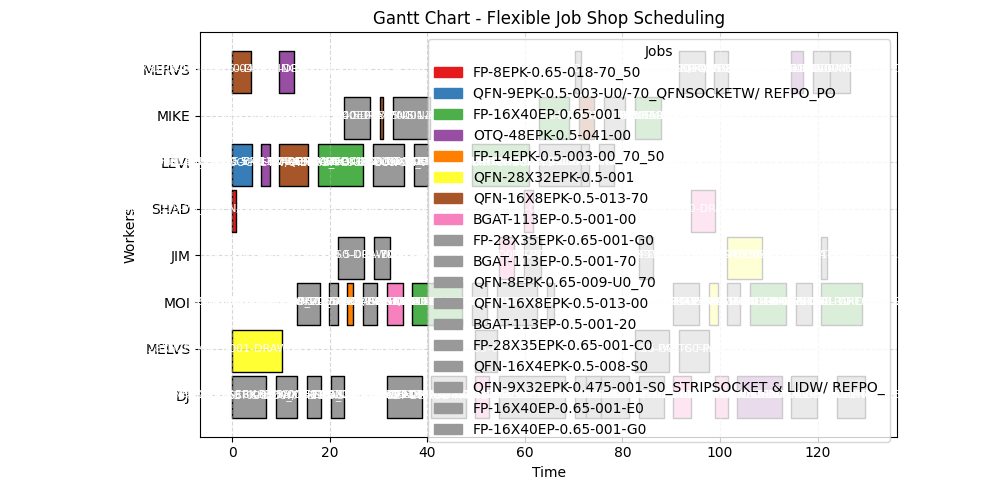

In [6]:
env = FJSP_Env(
    jobs=jobs,
    workers=workers,
    processing_times=processing_times,
    deadlines=deadlines,
    switch_penalty=2,
    ongoing_tasks = ongoing_tasks,
    not_same_pic = not_same_pic
)

q_agent = QLearningAgent(env)
q_agent.train(episodes=1500)

best_schedule, makespan = q_agent.get_best_schedule()
print(f"\nTotal Makespan: {makespan}")
display(pd.DataFrame(data=best_schedule, columns=['PN','Task','PIC','Start','Finish']))

# Display Gantt Chart
plot_gantt(best_schedule, env.workers)
pd.DataFrame(best_schedule, columns=['PN','Task','PIC','Start','Finish']).to_excel('schedule_ql_results.xlsx')

Episode 0: Total reward = -88756.86
Makespan: 161.16061330593908
Episode 0: Total reward = -94438.29
Makespan: 181.6861576660253
Episode 0: Total reward = -62646.62
Makespan: 140.6100891104402
Episode 0: Total reward = -51372.01
Makespan: 154.14003432153922
Episode 0: Total reward = -46268.22
Makespan: 175.95569720908583
Episode 0: Total reward = -127686.93
Makespan: 173.01464401551533
Episode 0: Total reward = -70287.85
Makespan: 169.1944658853989
Episode 0: Total reward = -94833.06
Makespan: 149.8474646720603
Episode 0: Total reward = -49674.12
Makespan: 147.63765954850928
Episode 0: Total reward = -81793.90
Makespan: 146.86521702826656
Episode 0: Total reward = -54607.79
Makespan: 158.30013110549942
Episode 0: Total reward = -69098.72
Makespan: 129.15615897469723
Episode 0: Total reward = -64056.00
Makespan: 131.65387285319505
Episode 0: Total reward = -55936.79
Makespan: 150.093372378159
Episode 0: Total reward = -61112.86
Makespan: 135.27830430007762
Episode 0: Total reward = -805

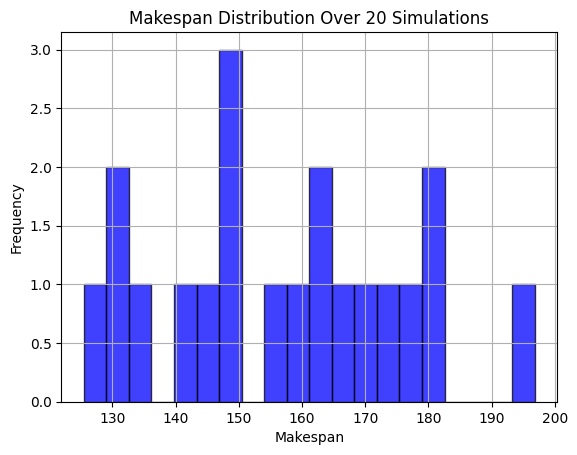

In [7]:
import matplotlib.pyplot as plt

def run_multiple_simulations(q_agent, num_simulations=100):
    makespans = []
    
    for _ in range(num_simulations):
        env = FJSP_Env(
            jobs=jobs,
            workers=workers,
            processing_times=processing_times,
            deadlines=deadlines,
            switch_penalty=2, 
            ongoing_tasks = ongoing_tasks,
            not_same_pic = not_same_pic
        )
        
        q_agent = QLearningAgent(env)
        q_agent.train(episodes=500)
        _, makespan = q_agent.get_best_schedule()
        print(f"Makespan: {makespan}")
        makespans.append(makespan)
    
    return makespans

# Run simulations
num_simulations = 20
makespan_results = run_multiple_simulations(q_agent, num_simulations)

# Calculate statistics
mean_makespan = np.mean(makespan_results)
median_makespan = np.median(makespan_results)
variance_makespan = np.var(makespan_results)

print(f"Mean Makespan: {mean_makespan}")
print(f"Median Makespan: {median_makespan}")
print(f"Variance: {variance_makespan}")

# Plot histogram
plt.hist(makespan_results, bins=20, alpha=0.75, color='blue', edgecolor='black')
plt.xlabel("Makespan")
plt.ylabel("Frequency")
plt.title(f"Makespan Distribution Over {num_simulations} Simulations")
plt.grid(True)
plt.show()


#### Monte Carlo Tree Search

In [8]:
import numpy as np
import random
import math

class MCTSNode:
    def __init__(self, env, state, parent=None, action=None):
        self.state = state
        self.parent = parent
        self.action = action
        self.children = {}
        self.visits = 0
        self.total_reward = 0.0
        self.env = env

    def all_actions_explored(self):
        """Check if all possible actions have been explored."""
        return len(self.children) == len(set(self.env.get_possible_actions()))
    
    def best_child(self, exploration_weight=1.4):
        """Select the best child based on UCT score."""
        return max(self.children.values(), key=lambda child: child.uct_score(self.visits, exploration_weight))

    def uct_score(self, parent_visits, exploration_weight):
        """Compute the UCT score (Exploitation + Exploration)."""
        if self.visits == 0:
            return float('inf')  # Prioritize unexplored nodes
        exploitation = self.total_reward / self.visits
        exploration = exploration_weight * math.sqrt(math.log(parent_visits) / self.visits)
        return exploitation + exploration

    def expand(self):
        """Expand a child node with an untried action."""
        possible_actions = self.env.get_possible_actions()        
        random.shuffle(possible_actions)  # Prevent bias
        for action in possible_actions:
            if action not in self.children:
                env_copy = self.env.create_copy()
                _, _, _ = env_copy.step(action)
                new_state = env_copy.get_state()
                self.children[action] = MCTSNode(env_copy, new_state, parent=self, action=action)
                return self.children[action] 
        return None    

   

    def update(self, reward):
        """Backpropagate the reward up the tree."""
        self.visits += 1
        self.total_reward += reward
        if self.parent:
            self.parent.update(reward)

class MCTSAgent:
    def __init__(self, env, iterations=4000, exploration_weight=1.4):
        self.env = env
        self.iterations = iterations
        self.exploration_weight = exploration_weight

    def search(self, state):
        root = MCTSNode(self.env.create_copy(), state)
        
        for _ in range(self.iterations):
            node = root
            
            # Selection
            while node.all_actions_explored() and node.children:
                node = node.best_child(self.exploration_weight)
            
            # Expansion
            new_node = node.expand()
            if new_node:
                node = new_node
            
            # Simulation
            env_copy = node.env.create_copy()
            total_reward = 0
            gamma = 1.0
            discount_factor = 0.99
            
            for _ in range(1000):
                actions = env_copy.get_possible_actions()
                if not actions:
                    break
                action = random.choice(actions)
                _, reward, done = env_copy.step(action)
                total_reward += gamma * reward
                gamma *= discount_factor
                if done:
                    break
            
            # Backpropagation
            node.update(total_reward)
    

        if not root.children:
            return None
        return root.best_child(0).action


    def act(self):
        return self.search(self.env.get_state())

    def get_best_schedule(self):
        state = self.env.reset()
    
        possible_actions = self.env.get_possible_actions()
        print(f"[Debug] Initial possible actions: {len(possible_actions)}")
        if not possible_actions:
            print("[Error] No possible actions available at the start. Check environment setup.")
            return [], 0
    
        done = False
        while not done:
            action = self.act()
            if action is None:
                print("[Warning] MCTS returned no action. Ending early.")
                break
            state, _, done = self.env.step(action)
        return self.env.schedule, self.env.current_time


[Debug] Initial possible actions: 64
Final Makespan: 80.37139994574528


,PN,Task,PIC,Start,Finish
0,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,DJ,0.000000,7.000000
1,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO-3...,LEVI,0.000000,4.000000
2,BGAT-113EP-0.5-001-70,BGAT-113EP-0.5-001-70-2D ASSY CONCEPT,JIM,0.000000,3.449784
3,FP-28X35EPK-0.65-001-G0,FP-28X35EPK-0.65-001-G0-CONCEPT CHECKING,MOI,0.000000,2.954094
4,BGAT-113EP-0.5-001-70,BGAT-113EP-0.5-001-70-3D CONCEPT,SHAD,3.449784,5.518017
...,...,...,...,...,...
66,BGAT-113EP-0.5-001-00,BGAT-113EP-0.5-001-00-PARTS FINAL CHECKING,SHAD,64.994705,67.018438
67,FP-16X40EP-0.65-001,FP-16X40EP-0.65-001-MESLINK,MOI,57.101984,62.925381
68,QFN-16X8EPK-0.5-013-00,QFN-16X8EPK-0.5-013-00-PARTS INITIAL CHECKING,MERVS,62.561885,66.821533
69,FP-16X40EP-0.65-001,FP-16X40EP-0.65-001-PARTS FINAL CHECKING,MOI,62.925381,70.379130


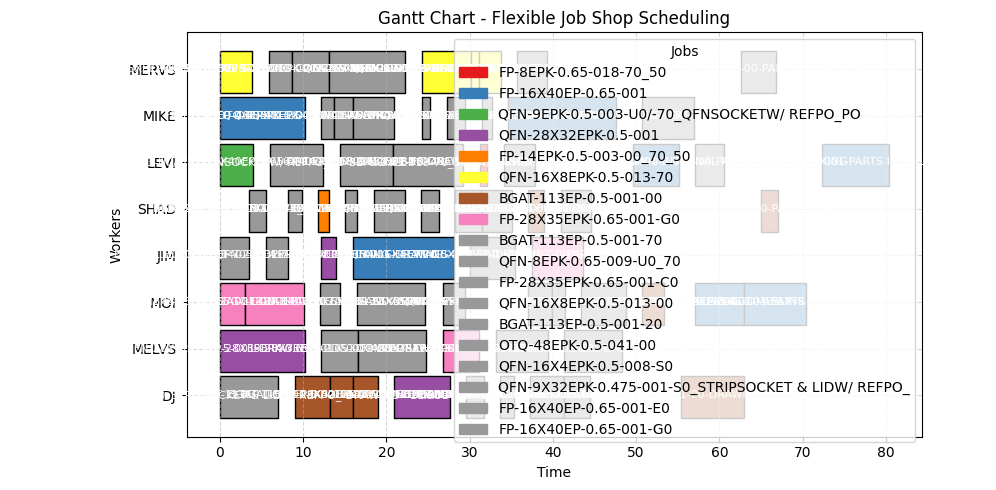

In [9]:
env = FJSP_Env(
    jobs=jobs,
    workers=workers,
    processing_times=processing_times,
    deadlines=deadlines,
    switch_penalty=2,
    ongoing_tasks = ongoing_tasks,
    not_same_pic = not_same_pic
)

# Run MCTS
mcts_agent = MCTSAgent(env)
best_schedule, makespan = mcts_agent.get_best_schedule()
print("Final Makespan:", makespan)
display(pd.DataFrame(data=best_schedule, columns=['PN','Task','PIC','Start','Finish']))
plot_gantt(best_schedule, env.workers)

pd.DataFrame(best_schedule, columns=['PN','Task','PIC','Start','Finish']).to_excel('schedule_mcts_results.xlsx')

#### Greedy Algorithm

In [18]:
class GreedyAgent:
    def __init__(self, env):
        self.env = env

    def choose_action(self):
        actions = self.env.get_possible_actions()
        if not actions:
            return None

        results = {}
        for action in actions:
            env_copy = self.env.create_copy()
            env_copy.step(action)
            results[action] = env_copy.current_time
        
        return min(results, key=results.get)   

    def get_best_schedule(self):
        state = self.env.reset()
        done = False
        while not done:
            action = self.choose_action()
            if action is None:
                break
            state, _, done = self.env.step(action)
        return self.env.schedule, self.env.current_time    

Final Makespan: 98.63212290764613


,PN,Task,PIC,Start,Finish
0,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,DJ,0.000000,7.000000
1,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO-3...,LEVI,0.000000,4.000000
2,FP-28X35EPK-0.65-001-C0,FP-28X35EPK-0.65-001-C0-CONCEPT CHECKING,MELVS,0.000000,5.211092
3,FP-28X35EPK-0.65-001-G0,FP-28X35EPK-0.65-001-G0-CONCEPT CHECKING,MOI,0.000000,2.978854
4,BGAT-113EP-0.5-001-00,BGAT-113EP-0.5-001-00-2D ASSY CONCEPT,JIM,0.000000,5.703745
...,...,...,...,...,...
66,FP-16X40EP-0.65-001,FP-16X40EP-0.65-001-DRAWING - 2D&3D PARTS,LEVI,57.944103,72.205597
67,FP-16X40EP-0.65-001,FP-16X40EP-0.65-001-INTERNAL REVISION,LEVI,72.205597,78.224224
68,FP-16X40EP-0.65-001,FP-16X40EP-0.65-001-MESLINK,DJ,78.224224,83.465255
69,FP-16X40EP-0.65-001,FP-16X40EP-0.65-001-PARTS FINAL CHECKING,DJ,83.465255,90.411288


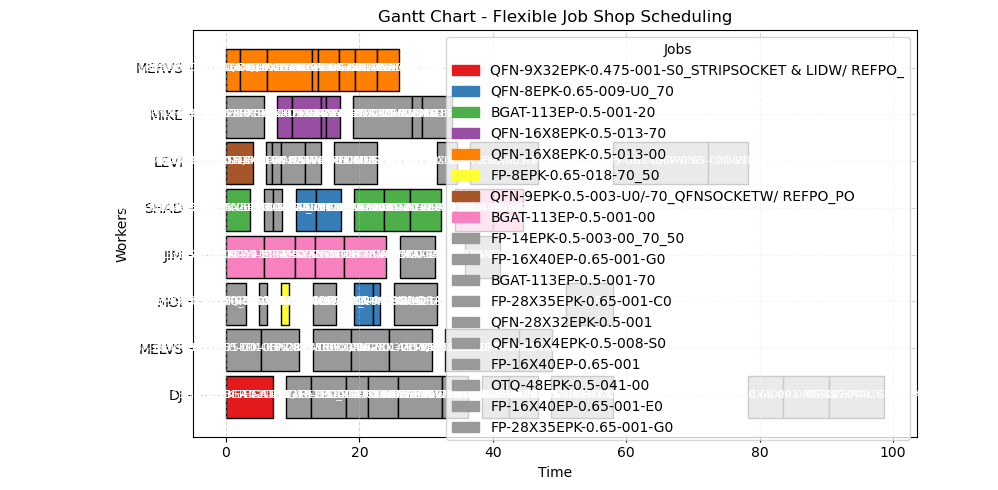

In [19]:
env = FJSP_Env(
    jobs=jobs,
    workers=workers,
    processing_times=processing_times,
    deadlines=deadlines,
    switch_penalty=2,
    ongoing_tasks = ongoing_tasks,
    not_same_pic = not_same_pic
)

greedy_agent = GreedyAgent(env)
best_schedule, makespan = greedy_agent.get_best_schedule()

print("Final Makespan:", makespan)
display(pd.DataFrame(best_schedule, columns=['PN','Task','PIC','Start','Finish']))
plot_gantt(best_schedule, env.workers)
pd.DataFrame(best_schedule, columns=['PN','Task','PIC','Start','Finish']).to_excel('schedule_greedy_results.xlsx')

#### Genetic Algorithm

In [20]:
import random

class GeneticAlgorithmSolver:
    def __init__(self, env, population_size=50, generations=100, crossover_rate=0.8, mutation_rate=0.2):
        self.env = env
        self.population_size = population_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate

    def initialize_population(self):
        population = []
        for _ in range(self.population_size):
            individual = self.random_individual()
            population.append(individual)
        return population

    def random_individual(self):
        task_list = [(job, sub) for job, subs in self.env.jobs.items() for sub in subs]
        random.shuffle(task_list)
        individual = []
        for job, sub in task_list:
            eligible_workers = list(self.env.processing_times[sub].keys())
            worker = random.choice(eligible_workers)
            individual.append((job, sub, worker))
        return individual

    def evaluate_fitness(self, individual):
        env_copy = self.env.create_copy()
        remaining_actions = individual[:]
        progress = True

        # Keep scheduling valid actions until no more progress
        while remaining_actions and progress:
            progress = False
            next_actions = []
            for action in remaining_actions:
                if env_copy.is_valid_action(*action):
                    env_copy.step(action)
                    progress = True
                else:
                    next_actions.append(action)
            remaining_actions = next_actions

        # Penalize individuals that did not complete all tasks
        total_tasks = sum(len(v) for v in self.env.jobs.values())
        completed_tasks = len(env_copy.completed_jobs)
        uncompleted_penalty = (total_tasks - completed_tasks) * 1000
        makespan = env_copy.current_time

        return 1 / (1 + makespan + uncompleted_penalty)

    def selection(self, population, fitnesses):
        total_fitness = sum(fitnesses)
        if total_fitness == 0:
            return random.sample(population, 2)
        return random.choices(population, weights=fitnesses, k=2)

    def crossover(self, parent1, parent2):
        cut = random.randint(1, len(parent1) - 2)
        child1 = parent1[:cut] + [gene for gene in parent2 if gene not in parent1[:cut]]
        child2 = parent2[:cut] + [gene for gene in parent1 if gene not in parent2[:cut]]
        return child1, child2

    def mutate(self, individual):
        new_individual = individual[:]
        if random.random() < 0.5:
            # Swap mutation
            i, j = random.sample(range(len(new_individual)), 2)
            new_individual[i], new_individual[j] = new_individual[j], new_individual[i]
        else:
            # Worker reassignment
            i = random.randint(0, len(new_individual) - 1)
            job, sub, _ = new_individual[i]
            eligible_workers = list(self.env.processing_times[sub].keys())
            new_worker = random.choice(eligible_workers)
            new_individual[i] = (job, sub, new_worker)
        return new_individual

    def solve(self):
        population = self.initialize_population()
        for _ in range(self.generations):
            fitnesses = [self.evaluate_fitness(ind) for ind in population]
            new_population = []
            while len(new_population) < self.population_size:
                parent1, parent2 = self.selection(population, fitnesses)
                if random.random() < self.crossover_rate:
                    child1, child2 = self.crossover(parent1, parent2)
                else:
                    child1, child2 = parent1[:], parent2[:]
                if random.random() < self.mutation_rate:
                    child1 = self.mutate(child1)
                if random.random() < self.mutation_rate:
                    child2 = self.mutate(child2)
                new_population.extend([child1, child2])
            population = new_population[:self.population_size]

        best_individual = max(population, key=self.evaluate_fitness)

        # Apply best schedule using the same logic
        env_copy = self.env.create_copy()
        remaining_actions = best_individual[:]
        progress = True
        while remaining_actions and progress:
            progress = False
            next_actions = []
            for action in remaining_actions:
                if env_copy.is_valid_action(*action):
                    env_copy.step(action)
                    progress = True
                else:
                    next_actions.append(action)
            remaining_actions = next_actions

        return env_copy.schedule, env_copy.current_time


Total Makespan: 124.48415986155538


,PN,Task,PIC,Start,Finish
0,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,DJ,0.000000,7.000000
1,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO-3...,LEVI,0.000000,4.000000
2,FP-8EPK-0.65-018-70_50,FP-8EPK-0.65-018-70_50-PN/PIN HOLE COUNT DETAILS,DJ,9.000000,10.043661
3,BGAT-113EP-0.5-001-70,BGAT-113EP-0.5-001-70-2D ASSY CONCEPT,MOI,0.000000,3.871495
4,BGAT-113EP-0.5-001-20,BGAT-113EP-0.5-001-20-2D ASSY CONCEPT,MOI,5.871495,9.742989
...,...,...,...,...,...
66,FP-16X40EP-0.65-001,FP-16X40EP-0.65-001-MESLINK,DJ,104.076261,109.317292
67,FP-16X40EP-0.65-001-G0,FP-16X40EP-0.65-001-G0-PARTS FINAL CHECKING,JIM,108.423552,113.610028
68,FP-16X40EP-0.65-001,FP-16X40EP-0.65-001-PARTS FINAL CHECKING,DJ,109.317292,116.263325
69,FP-16X40EP-0.65-001-G0,FP-16X40EP-0.65-001-G0-PARTS INITIAL CHECKING,MERVS,115.610028,118.566358


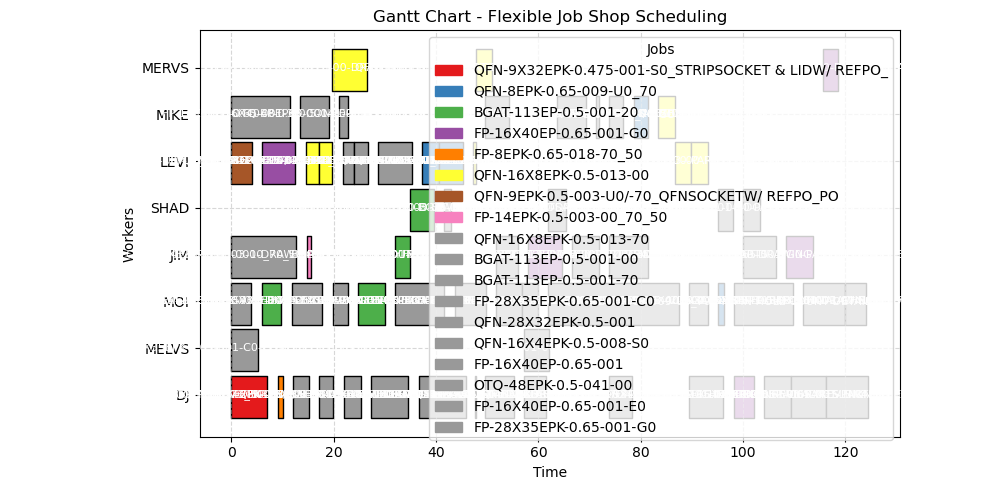

In [21]:
env = FJSP_Env(
    jobs=jobs,
    workers=workers,
    processing_times=processing_times,
    deadlines=deadlines,
    switch_penalty=2,
    ongoing_tasks = ongoing_tasks,
    not_same_pic = not_same_pic
)

ga_solver = GeneticAlgorithmSolver(env)
schedule, makespan = ga_solver.solve()

print(f"Total Makespan: {makespan}")
display(pd.DataFrame(schedule, columns=['PN','Task','PIC','Start','Finish']))


plot_gantt(schedule, env.workers)

pd.DataFrame(schedule, columns=['PN','Task','PIC','Start','Finish']).to_excel('schedule_ga_results.xlsx')

In [22]:
import matplotlib.pyplot as plt

def run_multiple_simulations(q_agent, num_simulations=100):
    makespans = []
    
    for _ in range(num_simulations):
        env = FJSP_Env(
            jobs=jobs,
            workers=workers,
            processing_times=processing_times,
            deadlines=deadlines,
            switch_penalty=2,
            ongoing_tasks = ongoing_tasks,
            not_same_pic = not_same_pic
        )
        
        ga_solver = GeneticAlgorithmSolver(env)
        schedule, makespan = ga_solver.solve()
        print(f"Makespan: {makespan}")
        makespans.append([schedule, makespan])
    
    return makespans

# Run simulations
num_simulations = 20
makespan_results = run_multiple_simulations(q_agent, num_simulations)

Makespan: 104.46197719110343
Makespan: 96.93699423028087
Makespan: 103.04181133617365
Makespan: 115.20668377723878
Makespan: 118.08731519204319
Makespan: 120.9702174382592
Makespan: 104.77360351843015
Makespan: 99.80565080428912
Makespan: 103.14696191464706
Makespan: 104.90973117542399
Makespan: 111.00487794515352
Makespan: 105.72680176172315
Makespan: 111.14443573379376
Makespan: 99.47242143253776
Makespan: 107.4742268303468
Makespan: 123.32709086505591
Makespan: 113.60396345030266
Makespan: 107.64269303887642
Makespan: 103.95463039117803
Makespan: 112.16433661413714


Mean Makespan: 108.34282123204973
Median Makespan: 106.60051429603497
Variance: 49.34775181942794


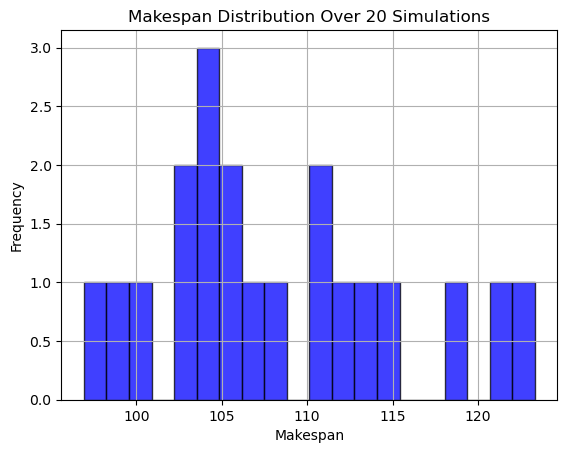

In [23]:
# Calculate statistics
makespans = [x[1] for x in makespan_results]
mean_makespan = np.mean(makespans)
median_makespan = np.median(makespans)
variance_makespan = np.var(makespans)

print(f"Mean Makespan: {mean_makespan}")
print(f"Median Makespan: {median_makespan}")
print(f"Variance: {variance_makespan}")

# Plot histogram
plt.hist(makespans, bins=20, alpha=0.75, color='blue', edgecolor='black')
plt.xlabel("Makespan")
plt.ylabel("Frequency")
plt.title(f"Makespan Distribution Over {num_simulations} Simulations")
plt.grid(True)
plt.show()

Total Makespan: 96.93699423028087


,PN,Task,PIC,Start,Finish
0,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,QFN-9X32EPK-0.475-001-S0_STRIPSOCKET & LIDW/ R...,DJ,0.000000,7.000000
1,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO,QFN-9EPK-0.5-003-U0/-70_QFNSOCKETW/ REFPO_PO-3...,LEVI,0.000000,4.000000
2,FP-8EPK-0.65-018-70_50,FP-8EPK-0.65-018-70_50-PN/PIN HOLE COUNT DETAILS,DJ,9.000000,10.043661
3,FP-16X40EP-0.65-001-G0,FP-16X40EP-0.65-001-G0-3D CONCEPT,LEVI,6.000000,12.475740
4,FP-28X35EPK-0.65-001-G0,FP-28X35EPK-0.65-001-G0-CONCEPT CHECKING,JIM,0.000000,3.804161
...,...,...,...,...,...
66,FP-16X40EP-0.65-001-E0,FP-16X40EP-0.65-001-E0-PARTS FINAL CHECKING,DJ,85.887017,89.955401
67,FP-16X40EP-0.65-001,FP-16X40EP-0.65-001-PARTS FINAL CHECKING,MIKE,74.959966,84.735840
68,FP-16X40EP-0.65-001,FP-16X40EP-0.65-001-PARTS INITIAL CHECKING,LEVI,86.735840,95.020474
69,QFN-16X8EPK-0.5-013-00,QFN-16X8EPK-0.5-013-00-PARTS FINAL CHECKING,MERVS,78.299678,81.521969


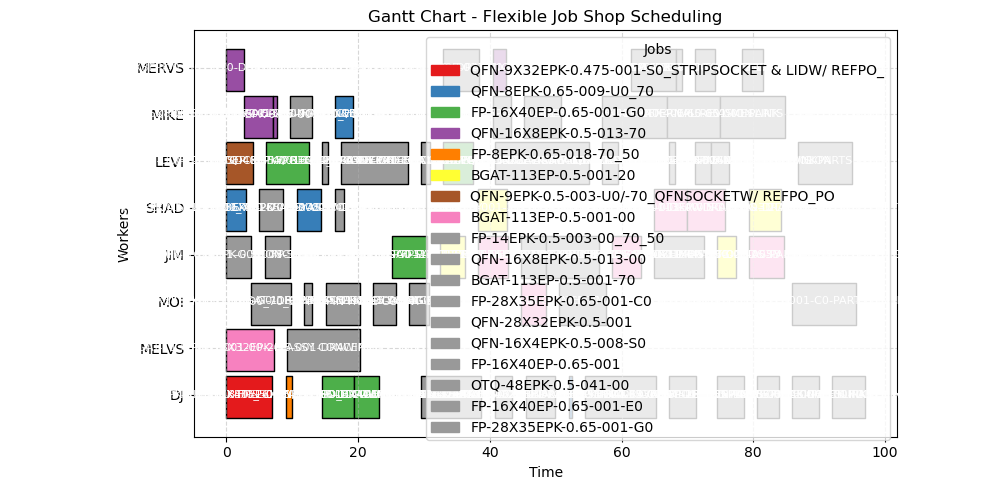

In [24]:
schedule, makespan = min(makespan_results, key=lambda x: x[1])

print(f"Total Makespan: {makespan}")
display(pd.DataFrame(schedule, columns=['PN','Task','PIC','Start','Finish']))


plot_gantt(schedule, env.workers)